In [2]:
!gdown 1nQDUEBgCF8087nPuLxNfBgJFeaJPaWoq

Downloading...
From: https://drive.google.com/uc?id=1nQDUEBgCF8087nPuLxNfBgJFeaJPaWoq
To: /content/kaggle.json
100% 69.0/69.0 [00:00<00:00, 364kB/s]


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data

Dataset URL: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data
License(s): CC0-1.0
new-york-city-airbnb-open-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip new-york-city-airbnb-open-data.zip

Archive:  new-york-city-airbnb-open-data.zip
replace AB_NYC_2019.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace New_York_City_.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [6]:
import pandas as pd
df = pd.read_csv("AB_NYC_2019.csv")

In [7]:
!pip install sweetviz --quiet

In [8]:
import sweetviz as sv

In [9]:
missing_values = df.isnull().mean() * 100
missing_values[missing_values > 0]

,0
name,0.032723
host_name,0.042949
last_review,20.558339
reviews_per_month,20.558339


                                             |          | [  0%]   00:00 -> (? left)


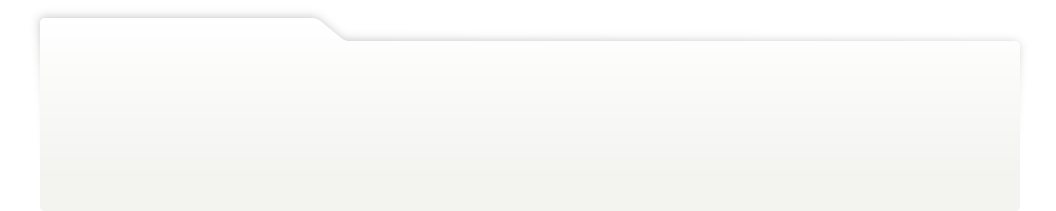
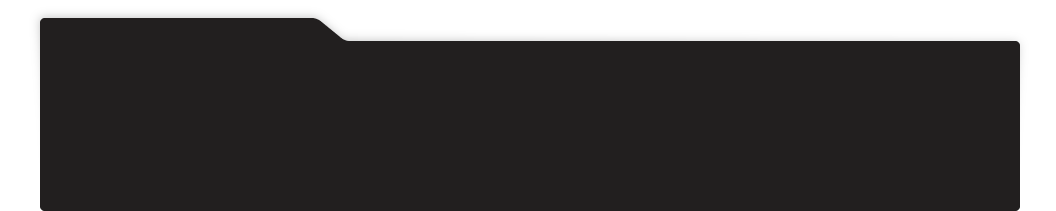
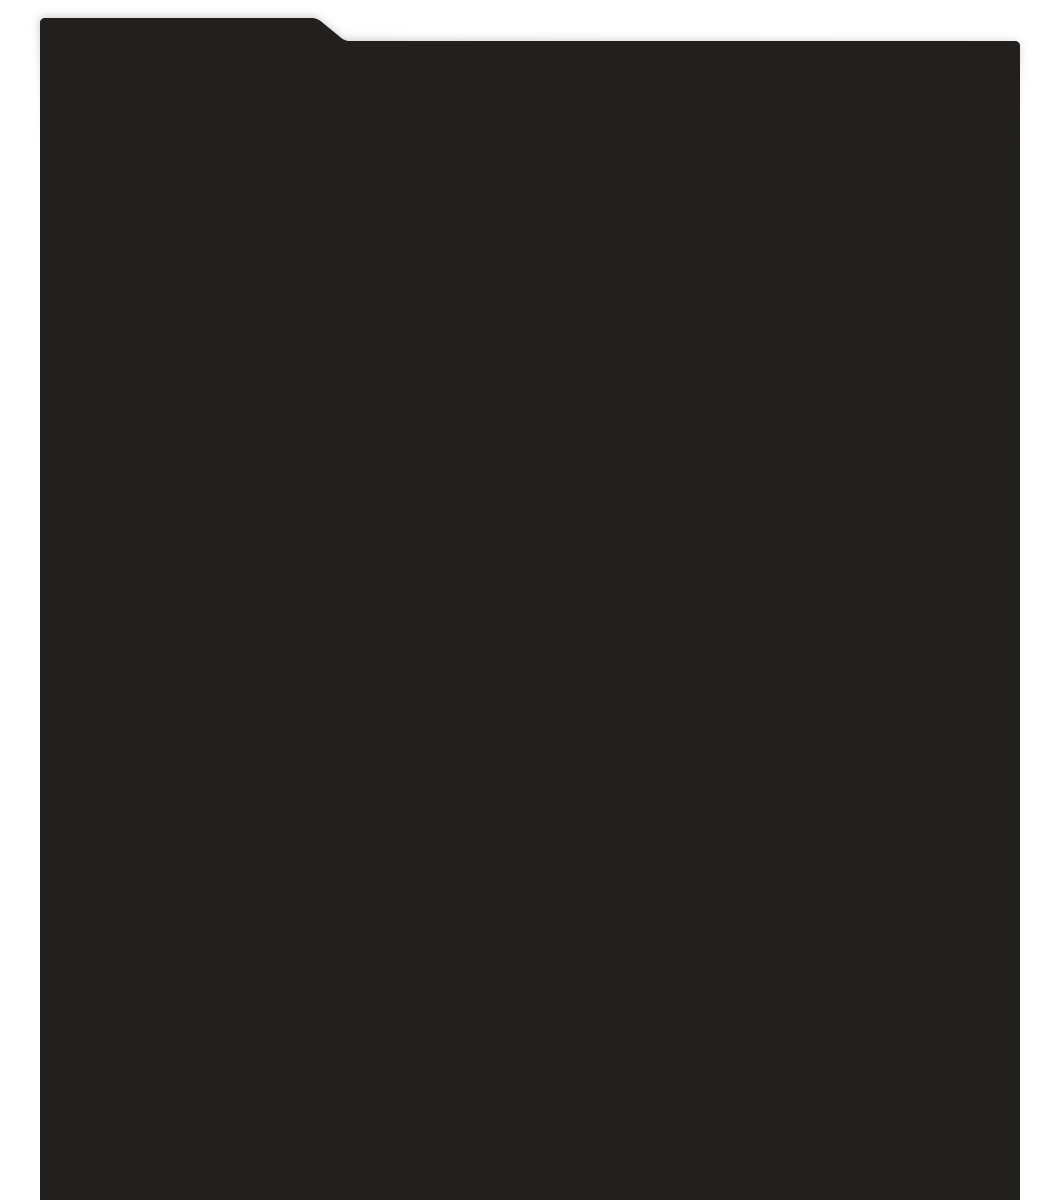
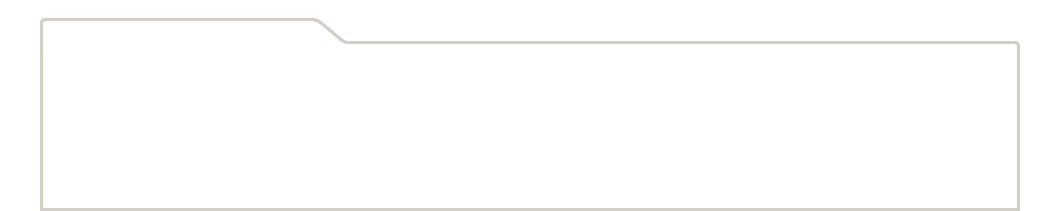
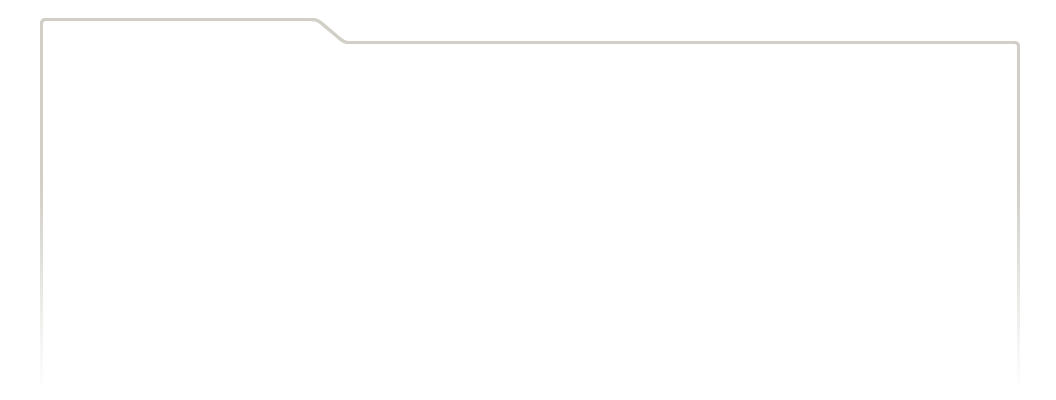
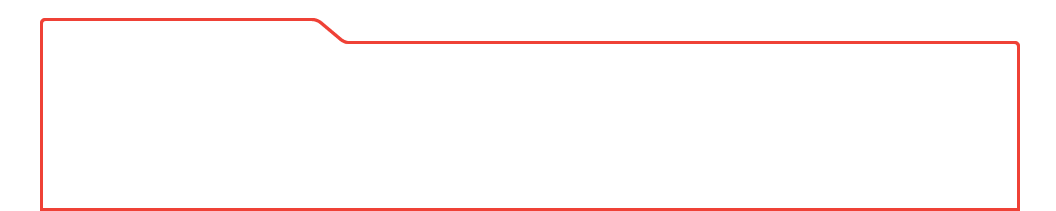
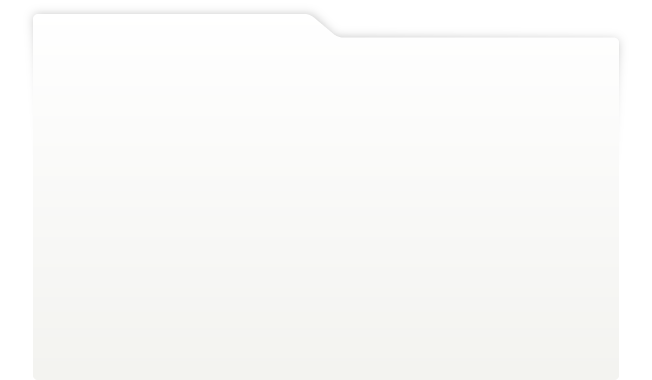
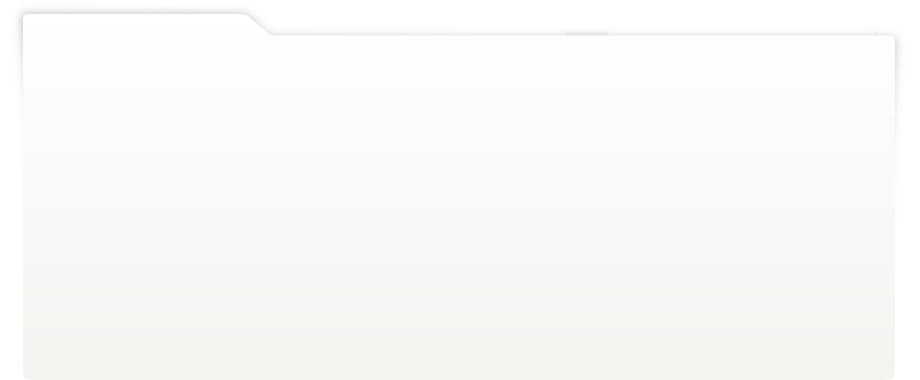
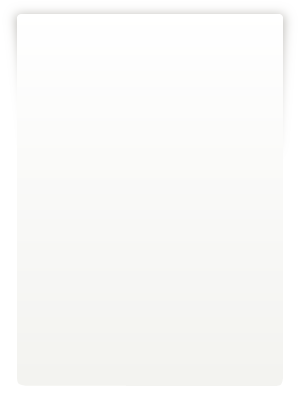
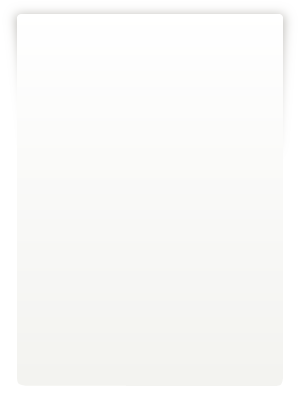
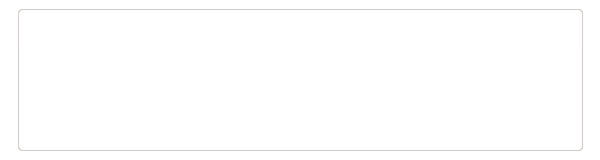
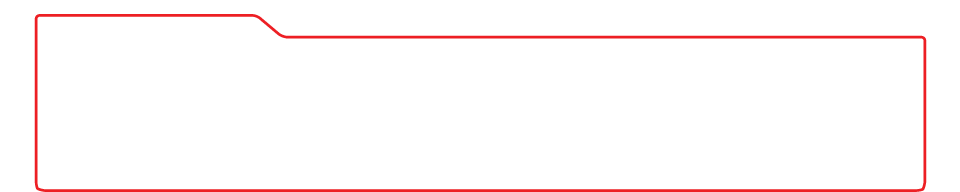
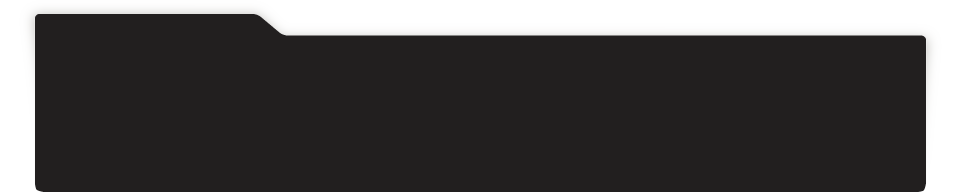
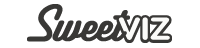
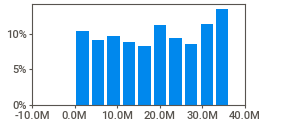
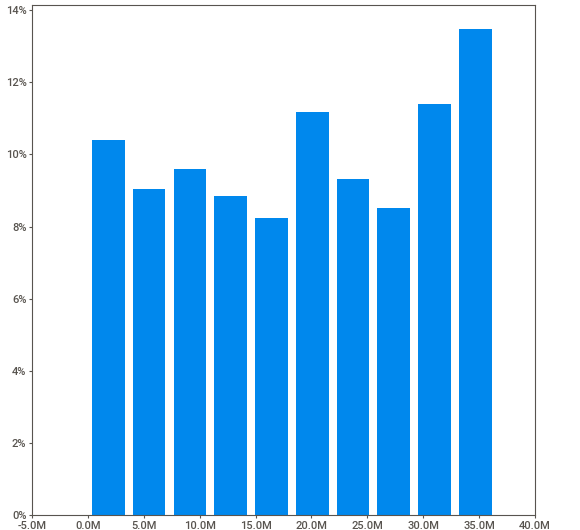
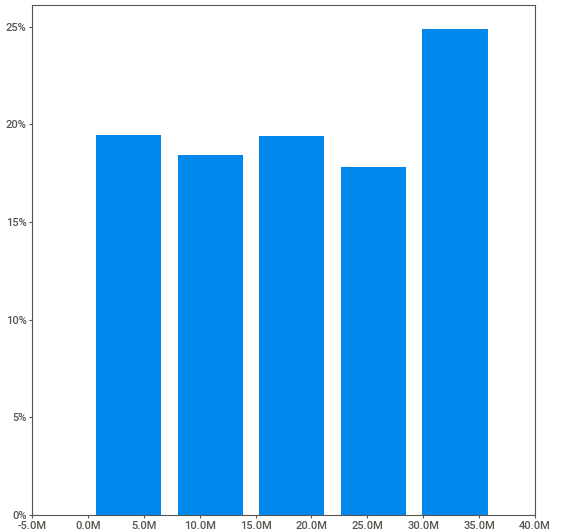
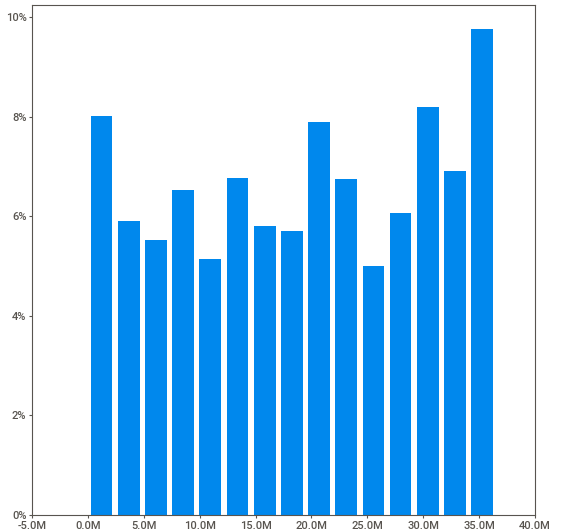
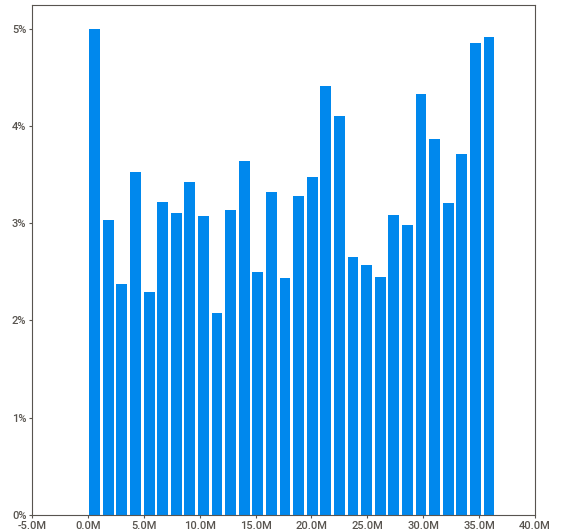
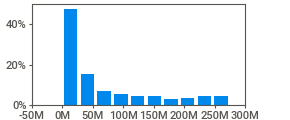
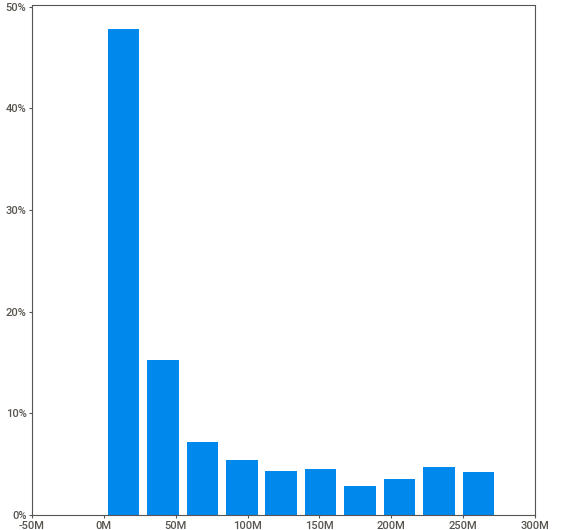
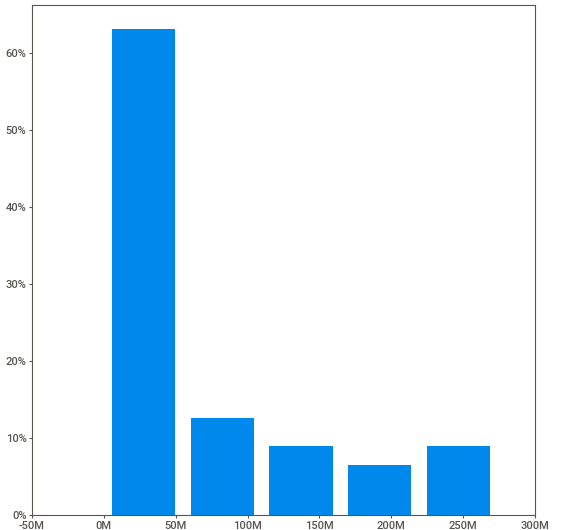
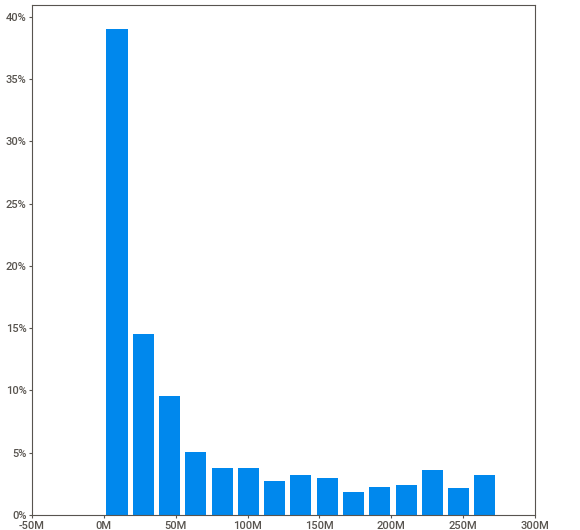
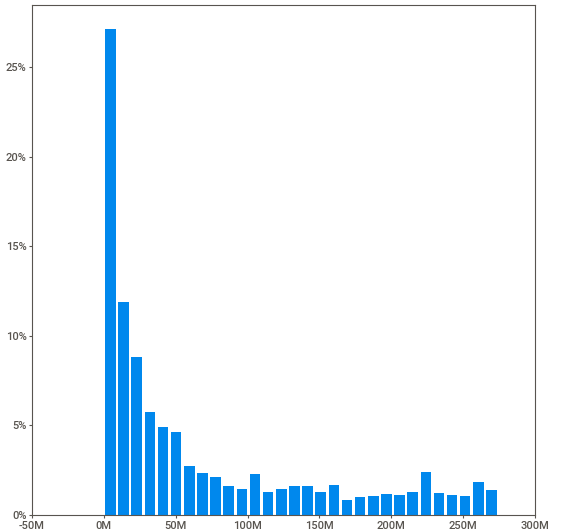
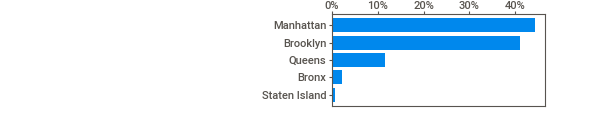
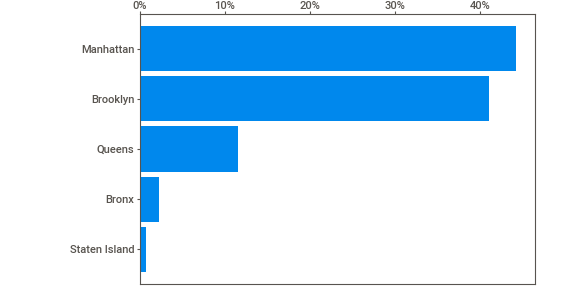
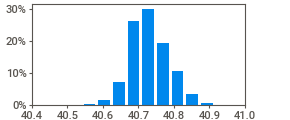
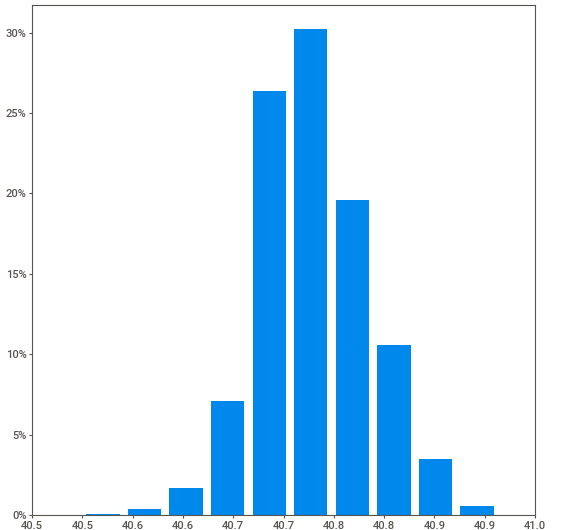
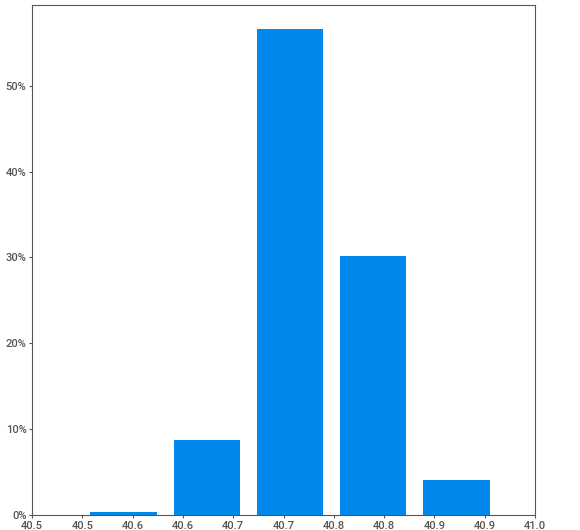
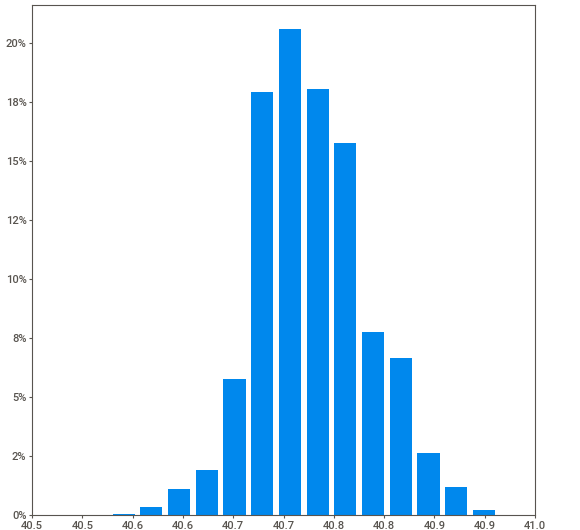
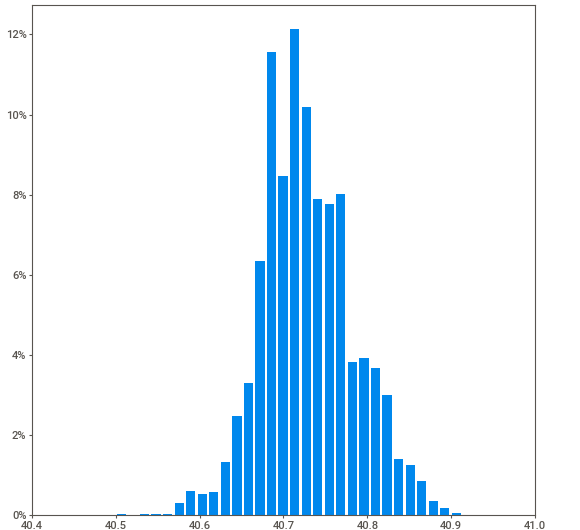
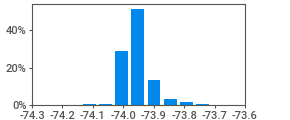
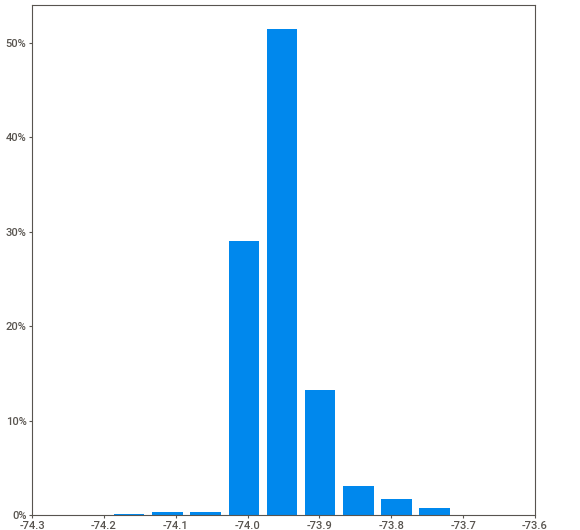
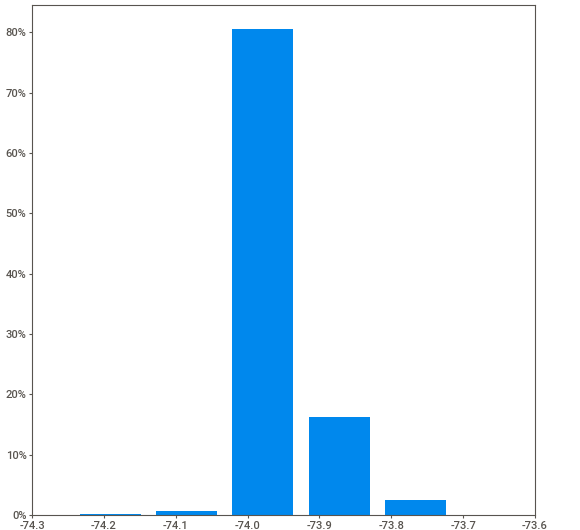
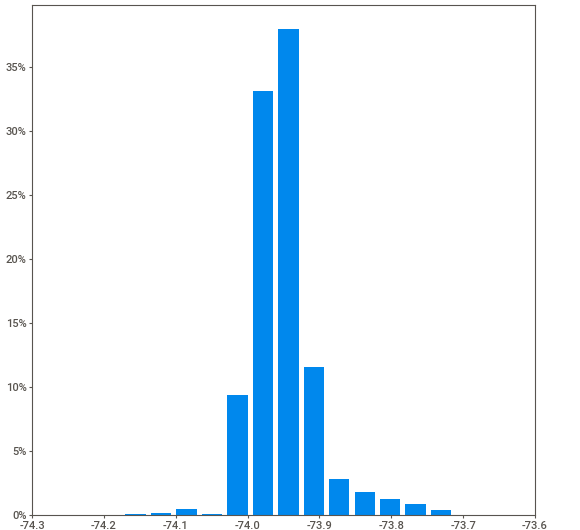
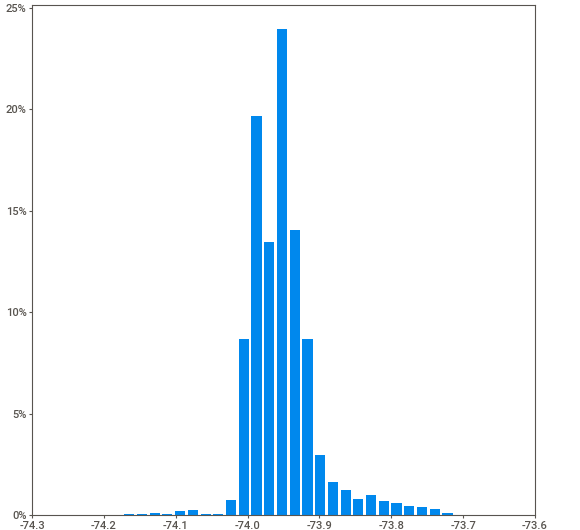
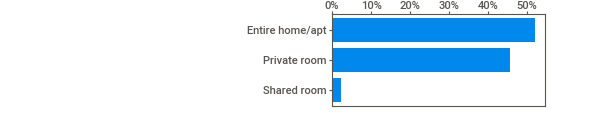
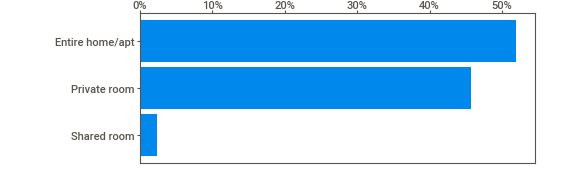
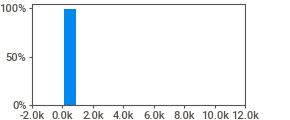
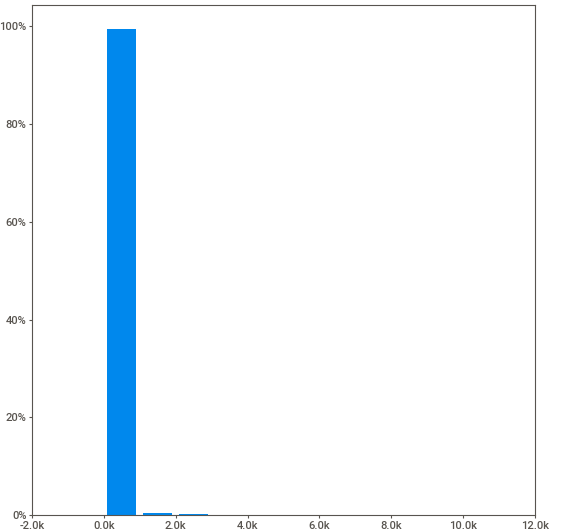
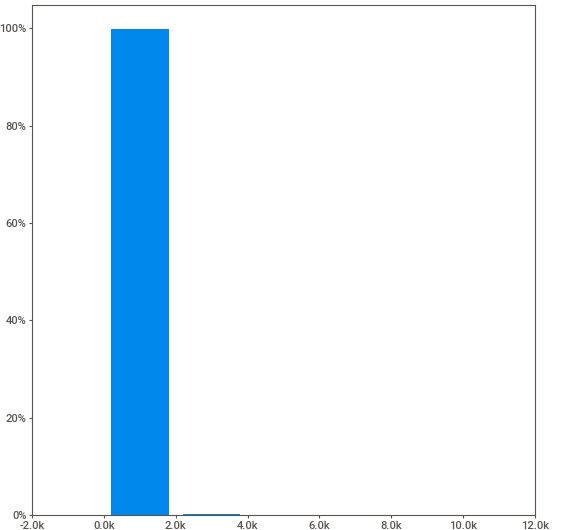
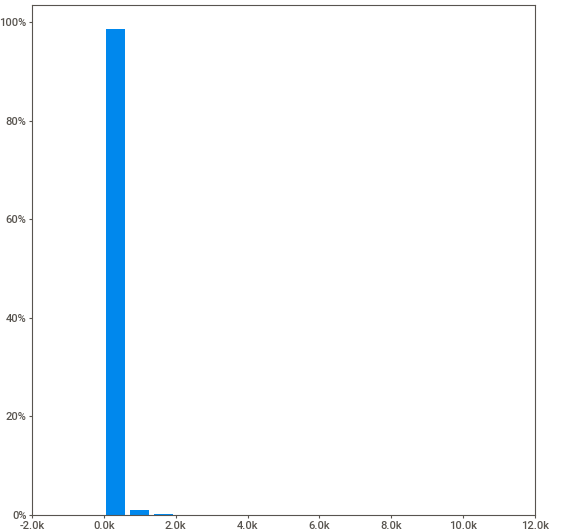
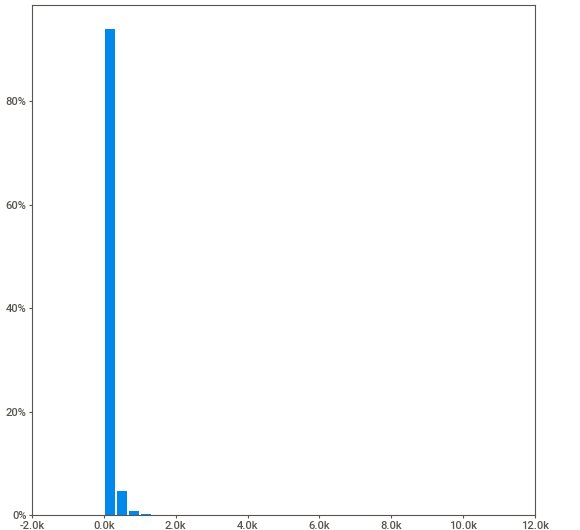
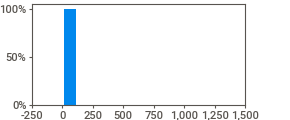
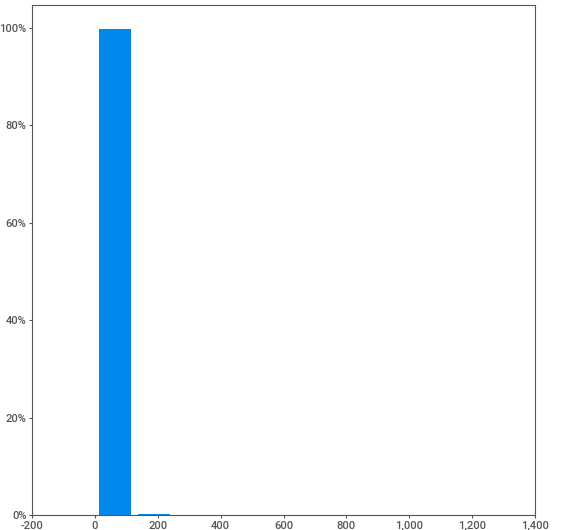
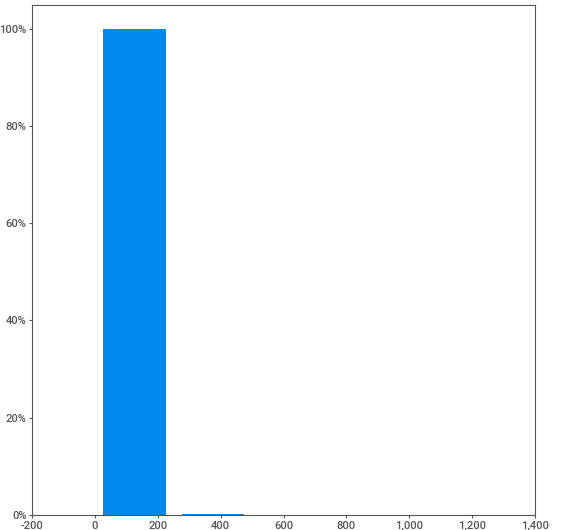
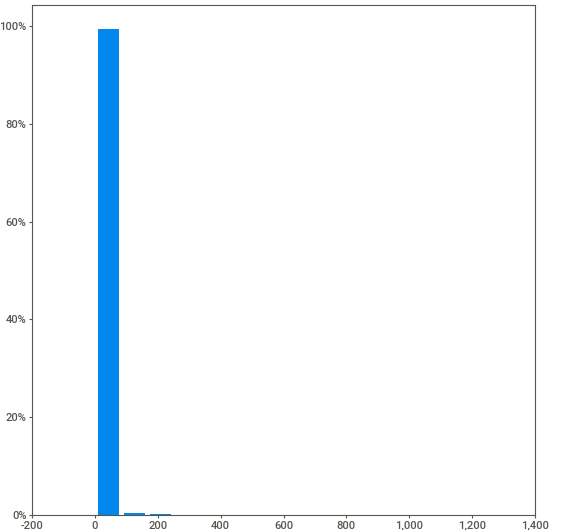
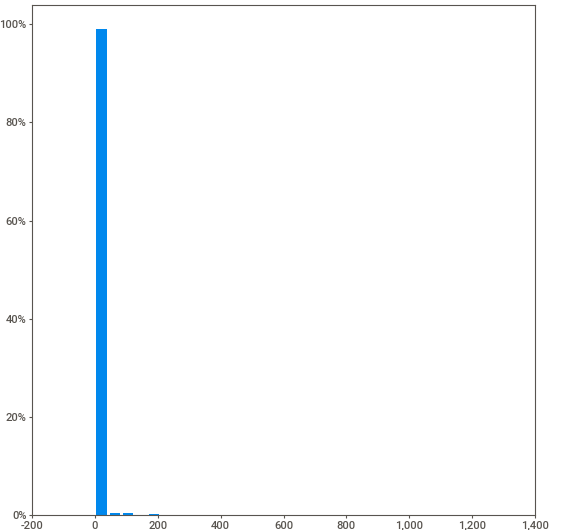
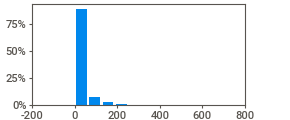
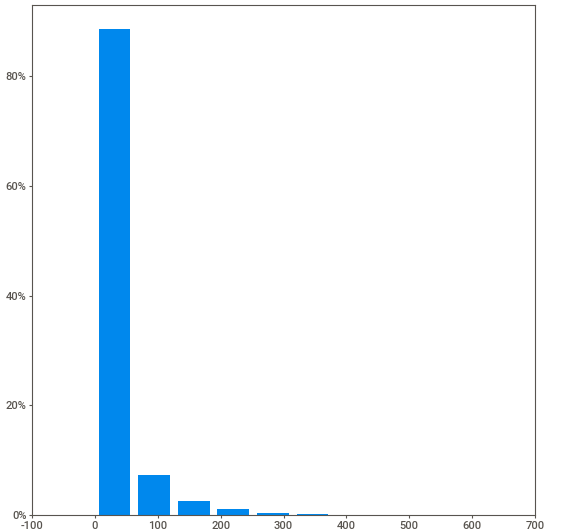
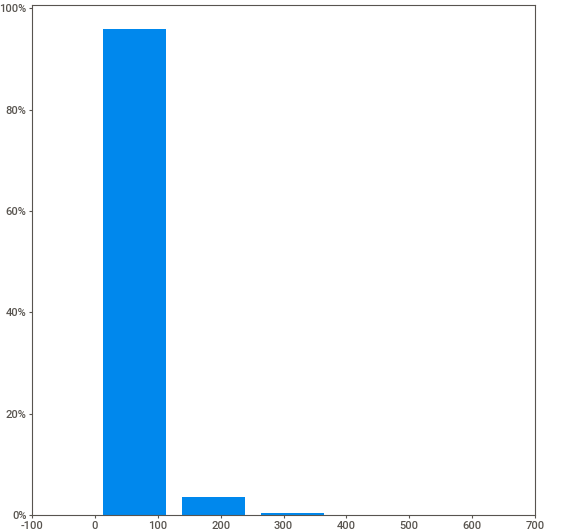
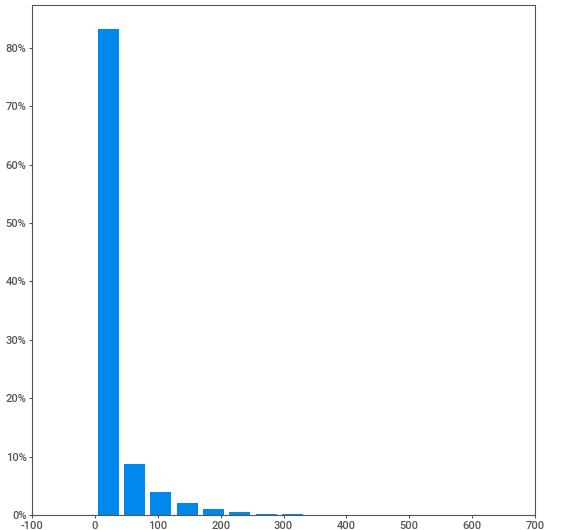
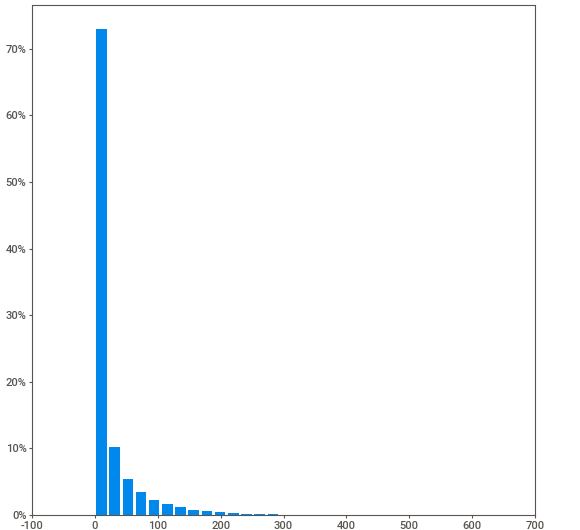
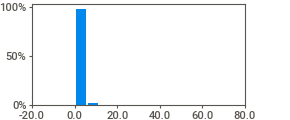
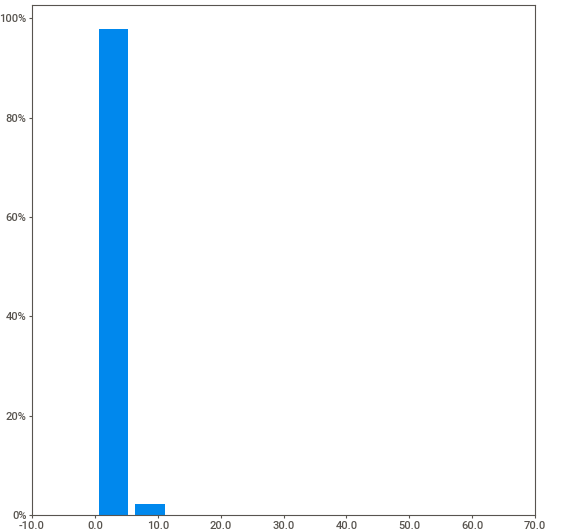
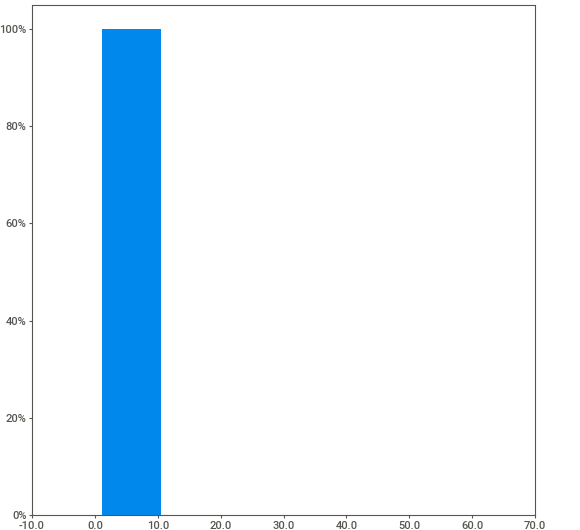
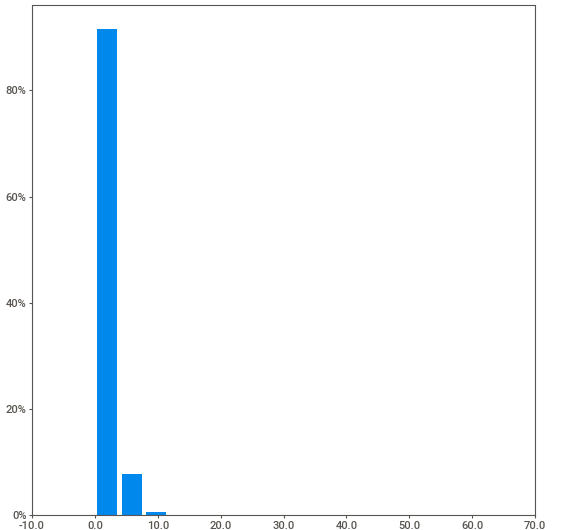
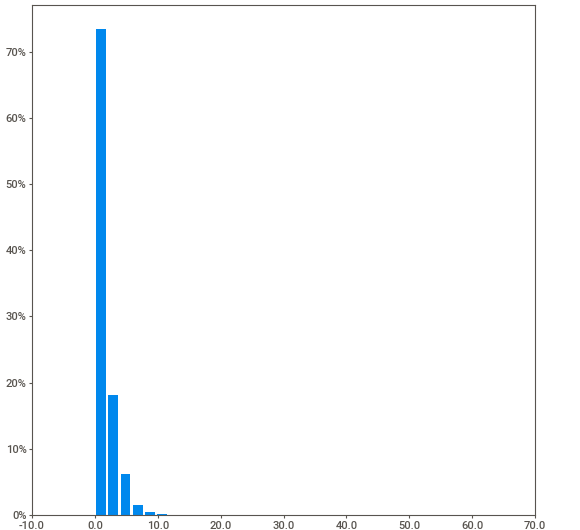
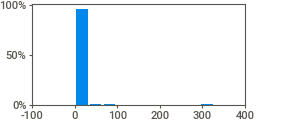
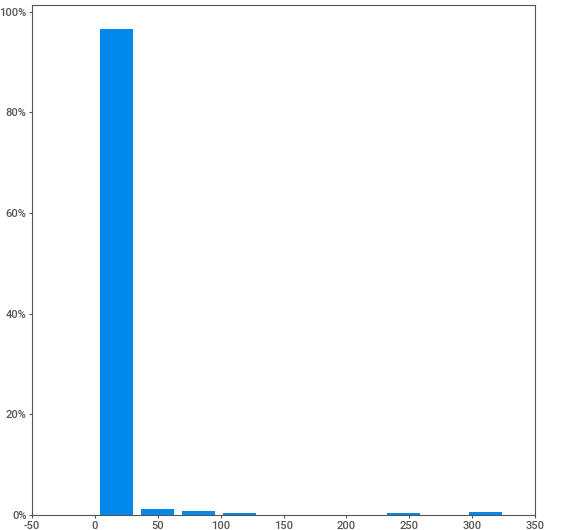
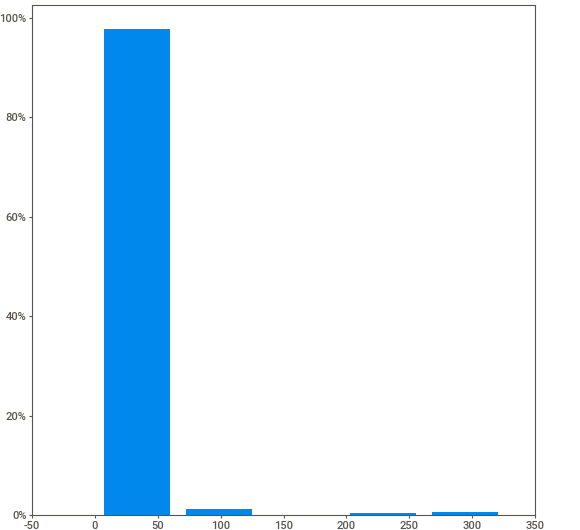
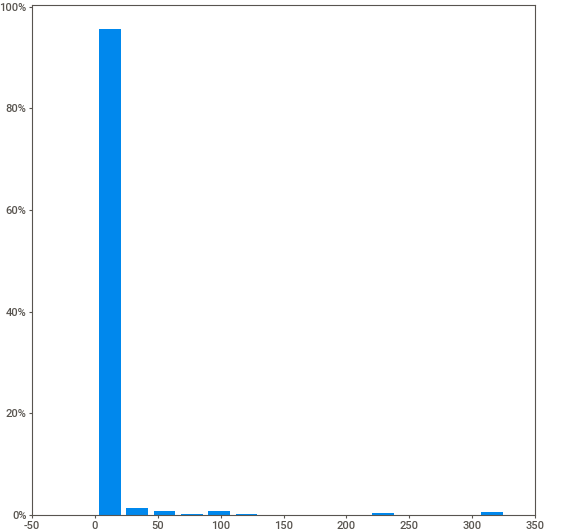
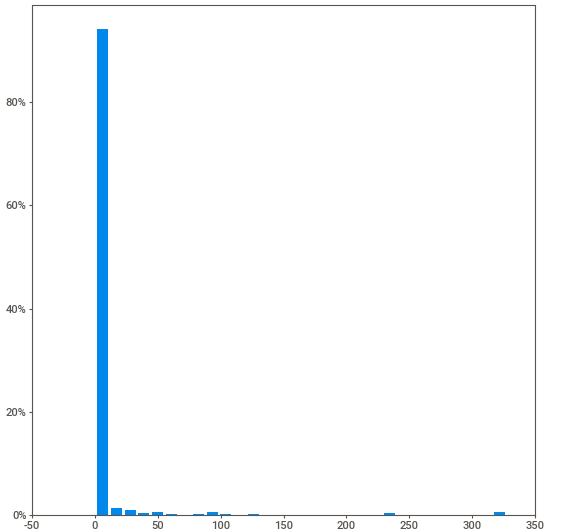
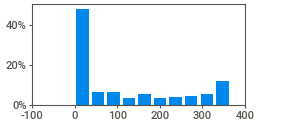
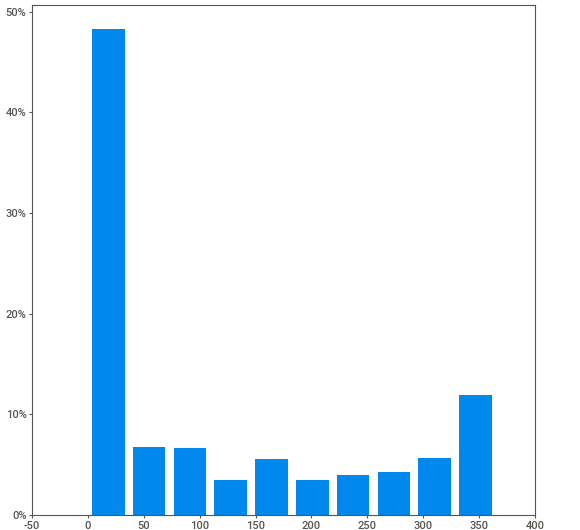
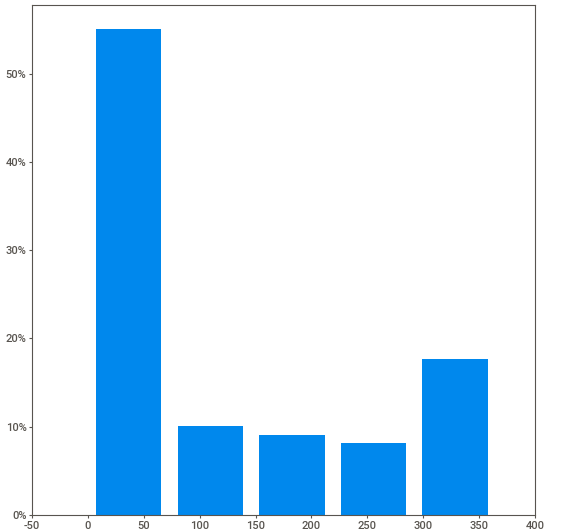
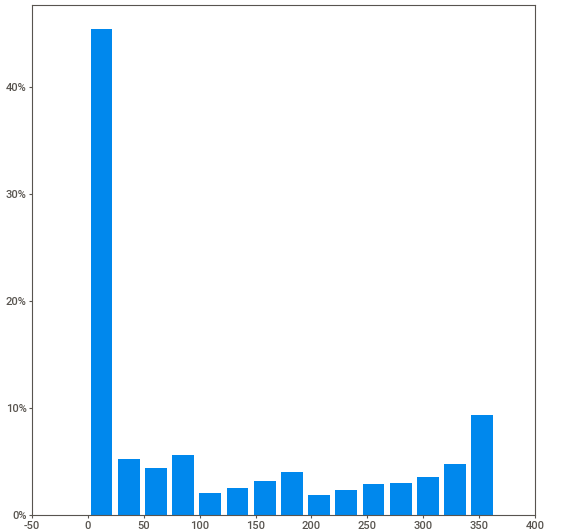
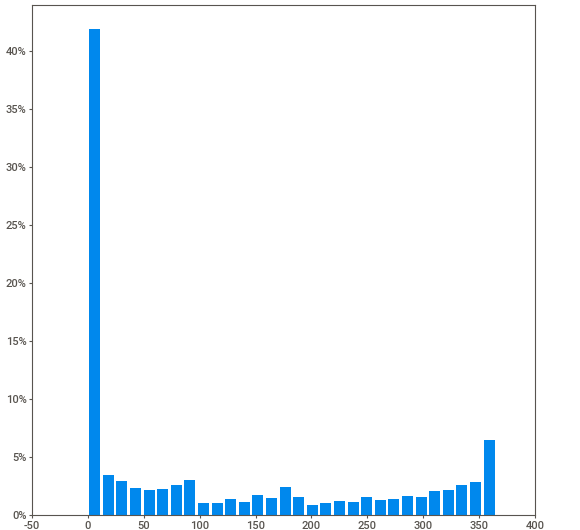
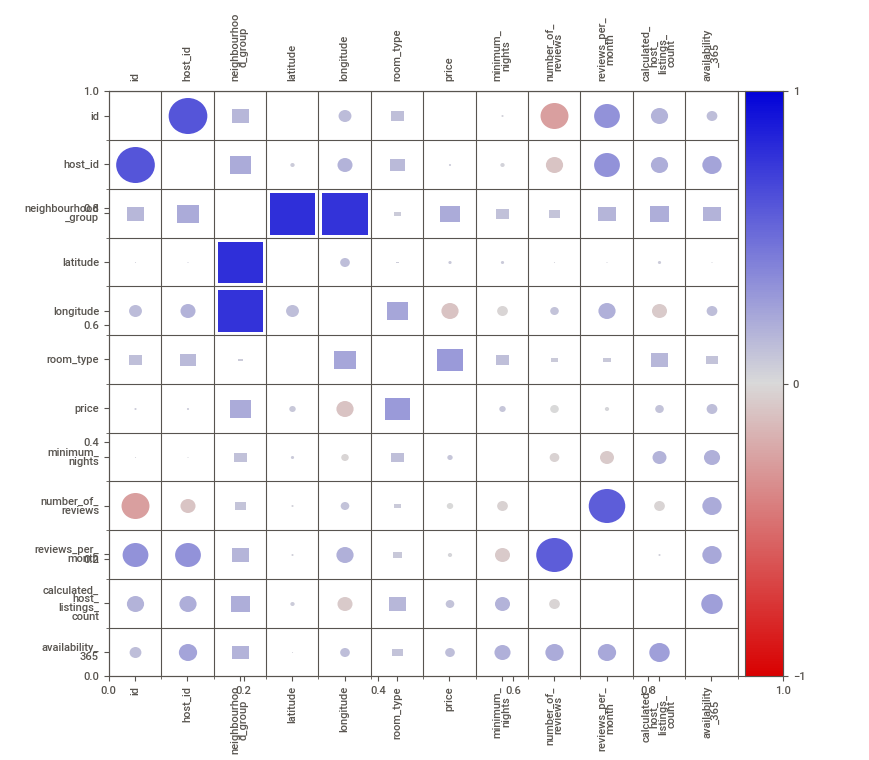
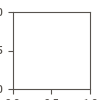

In [10]:
report = sv.analyze(df)
report.show_notebook()

# Data Preprocessing and Cleaning

## Impute missing values in reviews_per_month with the median


In [11]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(df['reviews_per_month'].median())
# Fill missing values in host_name with a placeholder
df['host_name'] = df['host_name'].fillna("Unknown")

## Handle extreme outliers

In [12]:
# Cap `price` at 99th percentile to handle extreme outliers
price_cap = df['price'].quantile(0.99)
df['price'] = df['price'].apply(lambda x: price_cap if x > price_cap else x)

## Perform one-hot encoding

In [13]:
df = pd.get_dummies(df, columns=['neighbourhood_group', 'room_type'], drop_first=True)

## Transforming data to standard scale

In [14]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# List of numerical columns to scale
num_cols = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'latitude', 'longitude']

# Apply scaling
df[num_cols] = scaler.fit_transform(df[num_cols])

# Handling highy correlated data

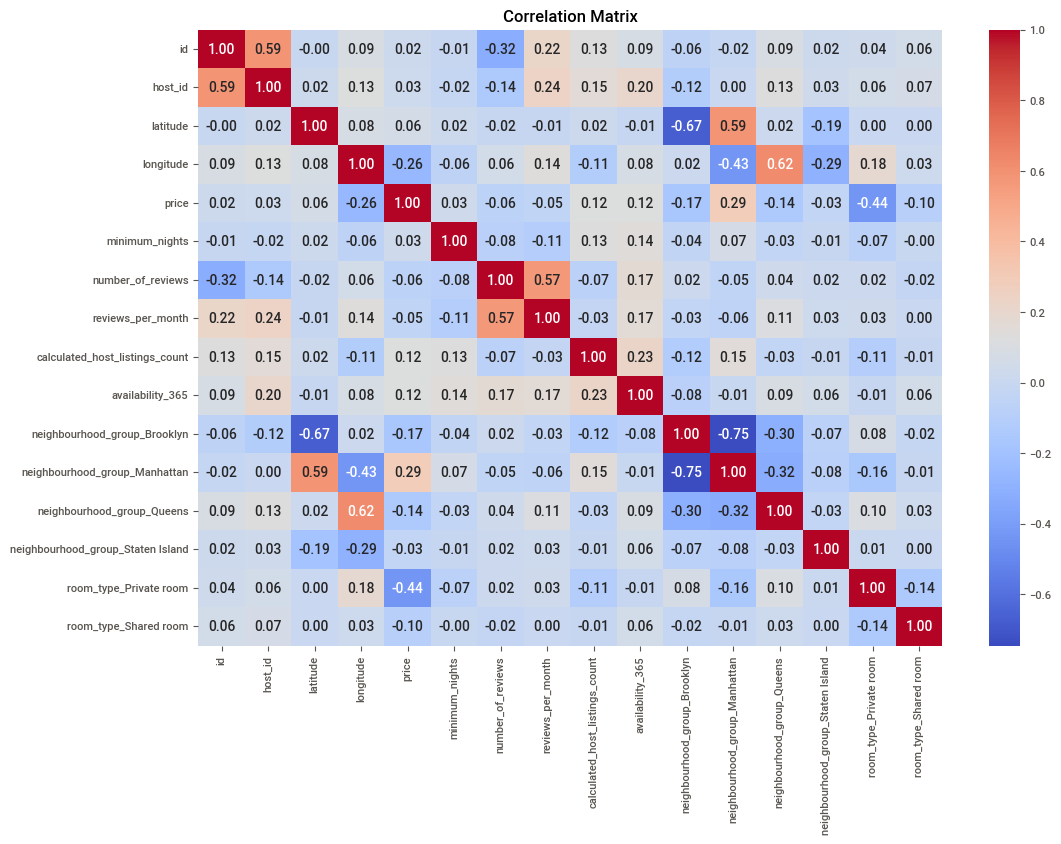

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
# Excluding non-numeric columns from the correlation calculation
numeric_df = df.select_dtypes(include=['number'])  # Select only numeric columns
corr_matrix = numeric_df.corr()

# Plot the correlation matrix for visualization
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Removing Anomility

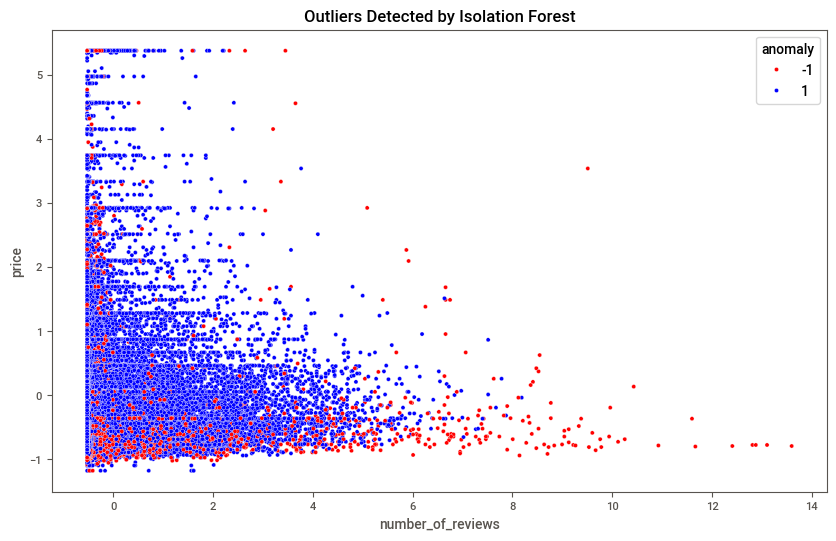

In [16]:
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer

# Assuming 'df' contains all necessary numerical features for outlier detection
# Assign 'df' to 'X' or copy if necessary
X = df.copy()  # Use copy to avoid modifying the original df

# Select only numerical columns for Isolation Forest
numerical_features = X.select_dtypes(include=['number']).columns
X_numerical = X[numerical_features]

# Impute NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies like 'median'
X_numerical_imputed = imputer.fit_transform(X_numerical)

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 5% of data as outliers

# Fit the model and predict anomalies using only numerical features
# Use the imputed data for fitting
df['anomaly'] = iso_forest.fit_predict(X_numerical_imputed)

# Extract the outliers
outliers = df[df['anomaly'] == -1]

# Plot outliers for visual inspection (e.g., based on price and number of reviews)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='number_of_reviews', y='price', hue='anomaly', palette={1: 'blue', -1: 'red'})
plt.title('Outliers Detected by Isolation Forest')
plt.show()

In [17]:
len(outliers)

2445

# Clustering Data

In [18]:
# Select relevant features for clustering
features_for_clustering = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']  # Adjust as necessary
X_cluster = df[features_for_clustering]

In [19]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


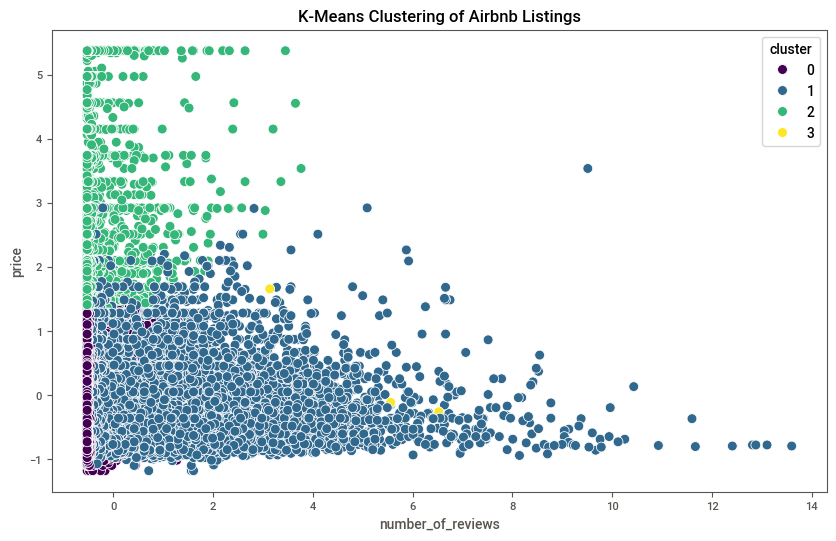

In [20]:
from sklearn.cluster import KMeans

# Fit K-Means with the selected number of clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Visualize the clusters based on two features (e.g., price and number of reviews)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='number_of_reviews', y='price', hue='cluster', palette='viridis', s=50)
plt.title('K-Means Clustering of Airbnb Listings')
plt.show()

# AutoML using VIML

In [21]:
!pip install autoviml

In [22]:
import numpy as np

# Custom function to replace scipy's deprecated interp
def interp(x, xp, fp):
    return np.interp(x, xp, fp)


In [23]:
!sed -i 's/from scipy import interp/import numpy as np\ninterp = lambda x, xp, fp: np.interp(x, xp, fp)/' /usr/local/lib/python3.10/dist-packages/autoviml/Auto_ViML.py


In [24]:
from autoviml.Auto_ViML import Auto_ViML


# Define the target and feature columns
target = 'price'  # Assuming we're predicting price
X = df.drop(columns=[target])
y = df[target]


Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
X_train[target] = y_train


##############  D A T A   S E T  A N A L Y S I S  #######################
ALERT! Changing hyperparameter search to RS. Otherwise, Random Forests will take too long for 10,000+ rows
Training Set Shape = (39116, 22)
    Training Set Memory Usage = 5.15 MB
Test Set Shape = (9779, 21)
    Test Set Memory Usage = 1.21 MB
Single_Label Target: ['price']

################ Regression VISUALIZATION Started #####################
No shuffling of data set before training...
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  5
    Number of Integer-Categorical Columns =  4
    Number of String-Categorical Columns =  0
    Numbe

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

Auto NLP processing on NLP Column: name
Shape of Train Data: 39116 rows
    Shape of Test Data: 9779 rows
    Added 9 summary columns for counts of words and characters in each row
Cleaning text in Train data for name column
    Faster text processing using clean_text function, since top_num_features is below 300
    Time Taken for Expanding emojis and abbreviations in data = 1 seconds
Auto_NLP error. Continuing without NLP processing


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

Auto NLP processing on NLP Column: host_name
Shape of Train Data: 39116 rows
    Shape of Test Data: 9779 rows
    Added 9 summary columns for counts of words and characters in each row
Cleaning text in Train data for host_name column
    Faster text processing using clean_text function, since top_num_features is below 300
    Time Taken for Expanding emojis and abbreviations in data = 0 seconds
Auto_NLP error. Continuing without NLP processing
Auto NLP processing on NLP Column: last_review
Shape of Train Data: 39116 rows
    Shape of Test Data: 9779 rows


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

    Added 9 summary columns for counts of words and characters in each row
Cleaning text in Train data for last_review column
    Faster text processing using clean_text function, since top_num_features is below 300
    Time Taken for Expanding emojis and abbreviations in data = 0 seconds
Auto_NLP error. Continuing without NLP processing
#######################################################################################
#####  SULOV:  Searching for Uncorrelated List Of Variables in 5 features ############
#######################################################################################
    there are no null values in dataset...


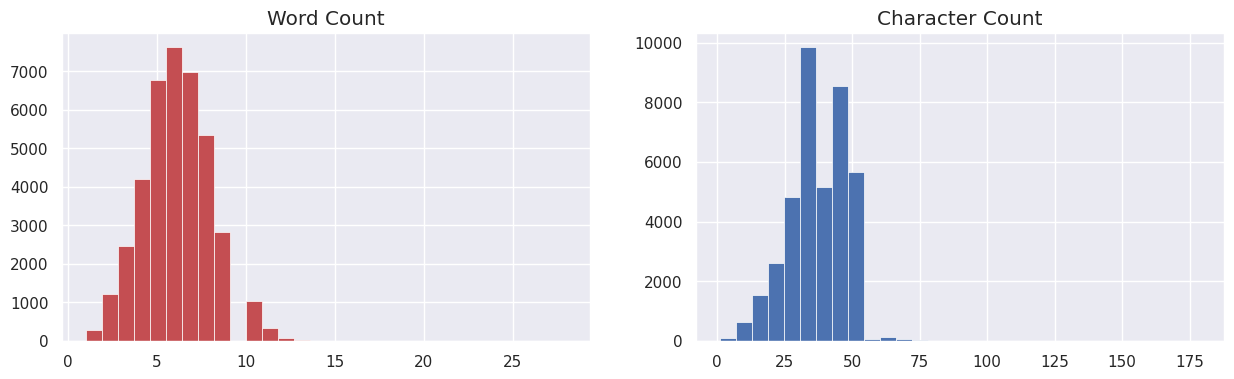

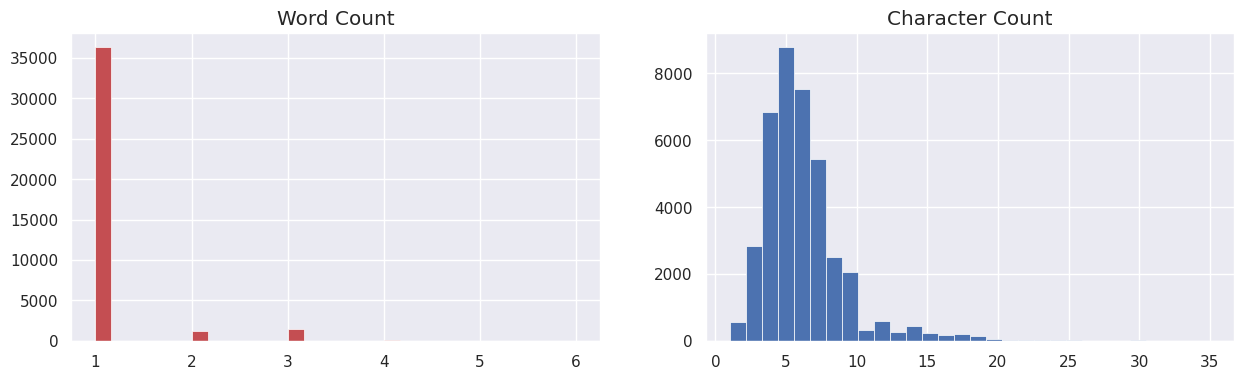

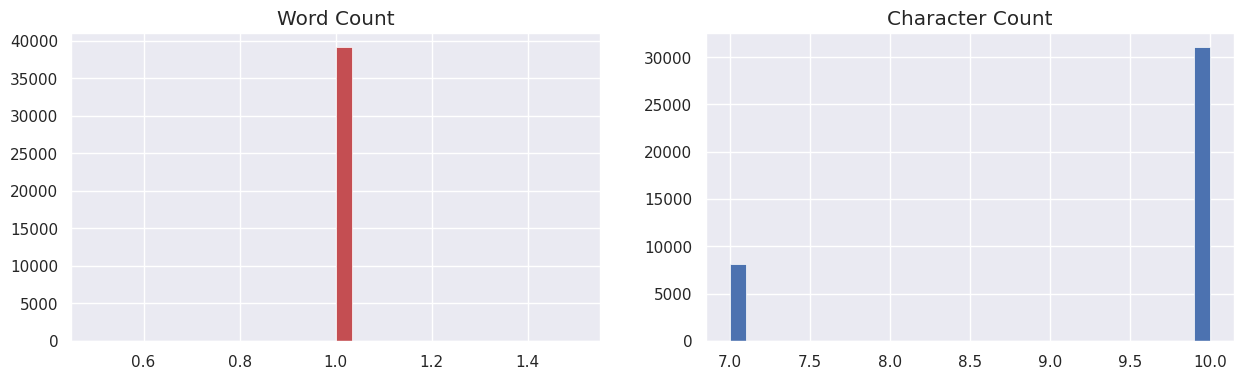

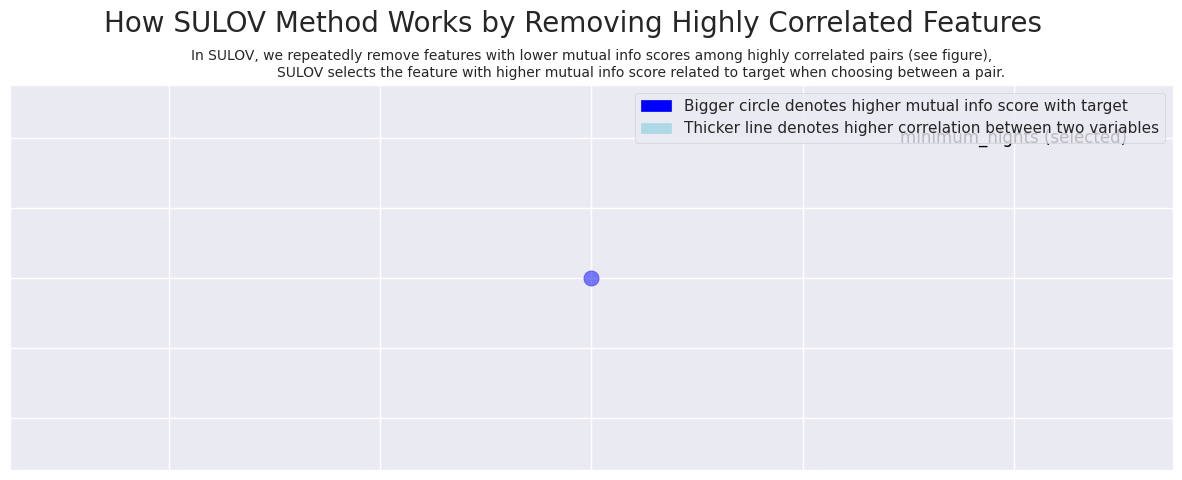

Splitting selected features into float and categorical (integer) variables:
    (5) float variables ...
    (14) categorical vars...
###############################################################################
#######     F E A T U R E   S E L E C T I O N    BY   X G B O O S T    ########
###############################################################################
Current number of predictors = 19 
    Finding Important Features using Boosted Trees algorithm...
        using 19 variables...
        using 15 variables...
        using 11 variables...
        using 7 variables...
        using 3 variables...
Found 15 important features
    Performing limited feature engineering for binning, add_poly and KMeans_Featurizer flags  ...
    Train CV Split completed with TRAIN rows =  31292 , CV rows =  7824
    Binning_Flag set to False or there are no float vars in data set to be binned
    KMeans_Featurizer set to False or there are no float variables in data
Performing MinMax scaling

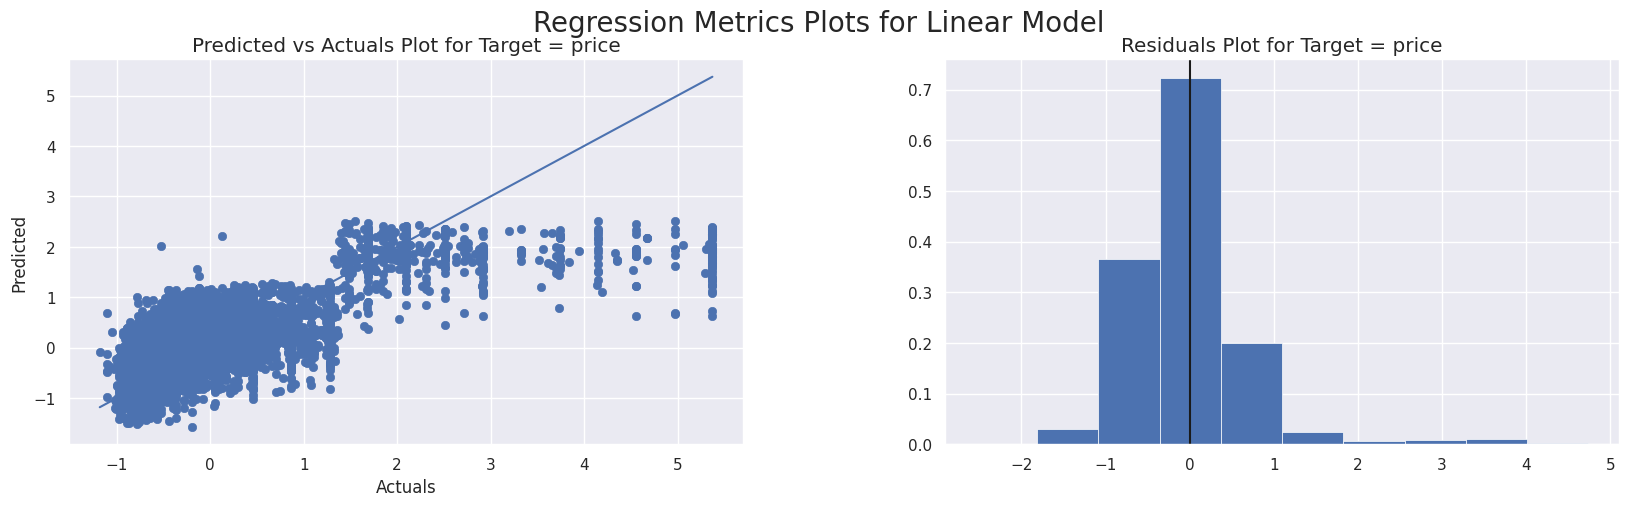

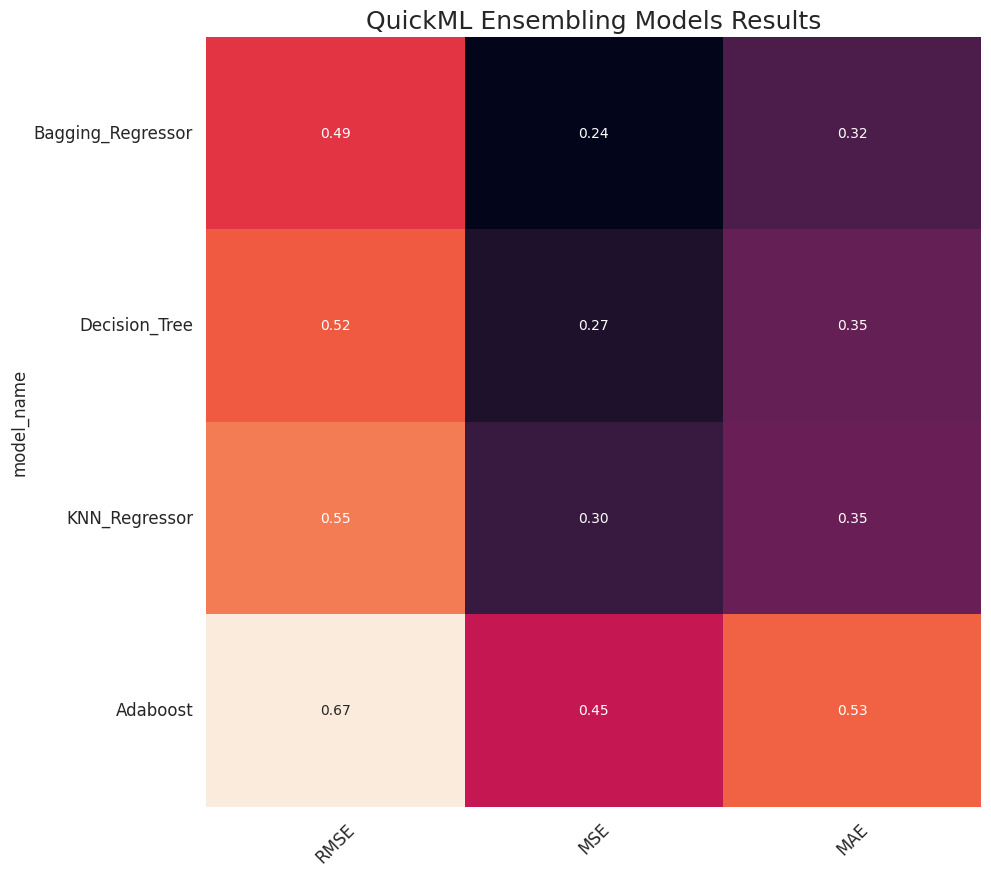

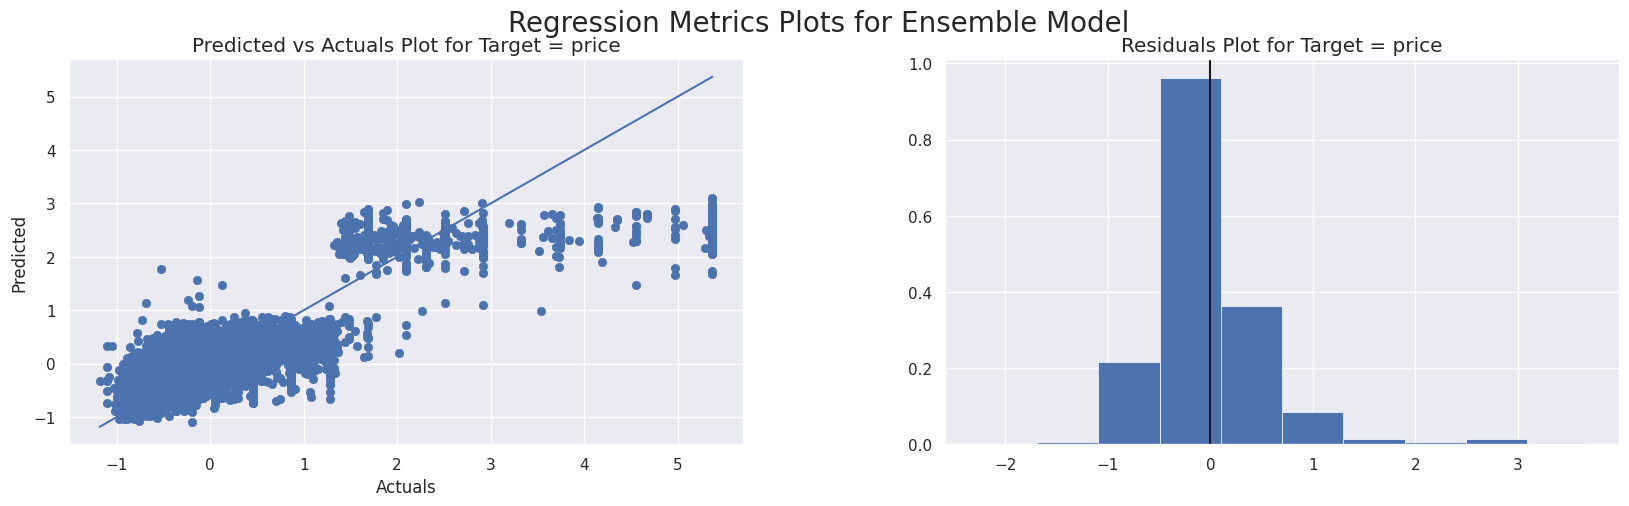

<Figure size 1500x500 with 0 Axes>

In [27]:
result = Auto_ViML(
    train=X_train, target=target, test=X_test, scoring_parameter='r2',
    hyper_param='RS', feature_reduction=True, verbose=1
)


In [39]:
model = result[0]
model

LinearSVR(C=9.361309329775258, epsilon=0.813308412782129, max_iter=4000,
          random_state=99, tol=0.001)

In [34]:
result[1]

['cluster',
 'room_type_Private room',
 'room_type_Shared room',
 'anomaly',
 'neighbourhood_group_Manhattan',
 'longitude',
 'minimum_nights',
 'last_review_Missing_Flag',
 'neighbourhood_group_Queens',
 'calculated_host_listings_count',
 'neighbourhood_group_Brooklyn',
 'availability_365',
 'host_id',
 'neighbourhood_group_Staten Island',
 'name_Missing_Flag']

In [35]:
result[2]

,cluster,room_type_Private room,room_type_Shared room,anomaly,neighbourhood_group_Manhattan,longitude,minimum_nights,last_review_Missing_Flag,neighbourhood_group_Queens,calculated_host_listings_count,neighbourhood_group_Brooklyn,availability_365,host_id,neighbourhood_group_Staten Island,name_Missing_Flag,price
32645,0,0,0,1,0,-0.07,-0.20,0,0,1,1,1,9038810,0,0,1.24
23615,0,1,0,1,1,0.25,-0.25,0,0,1,0,0,81745867,0,0,-0.61
31183,0,1,0,1,0,-0.16,-0.25,1,0,2,1,0,1218837,0,0,-0.70
29260,1,0,0,1,0,0.45,-0.20,0,0,1,1,267,4126686,0,0,-0.57
7275,0,1,0,1,0,1.22,-0.10,0,1,1,0,0,27698133,0,0,-0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0,0,1,1,1,0.19,-0.29,1,0,1,0,0,20261309,0,0,-0.69
44732,0,1,0,1,1,-1.05,-0.25,0,0,1,0,76,53254710,0,0,-0.48
38158,0,0,0,1,1,-0.47,1.12,0,0,5,0,261,1385157,0,0,-0.11
860,0,0,0,1,1,-0.60,-0.25,0,0,1,0,2,185753,0,0,0.05


In [36]:
result[3]

,id,cluster,room_type_Private room,room_type_Shared room,anomaly,neighbourhood_group_Manhattan,longitude,minimum_nights,last_review_Missing_Flag,neighbourhood_group_Queens,calculated_host_listings_count,neighbourhood_group_Brooklyn,availability_365,host_id,neighbourhood_group_Staten Island,name_Missing_Flag,price_Adaboost_predictions,price_Bagging_Regressor_predictions,price_KNN_Regressor_predictions,price_Decision_Tree_predictions,price_Linear_predictions,price_Ensembled_predictions,price_predictions
879,317905,0.00,0.00,0.00,1.00,0.00,0.50,0.00,0.00,0.00,0.00,1.00,0.52,0.01,0.00,0.00,-0.09,0.41,0.23,0.09,0.06,0.11,0.06
44383,34205267,0.00,1.00,0.00,1.00,0.00,0.63,0.02,1.00,1.00,0.00,0.00,0.20,0.00,0.00,0.00,-0.09,-0.71,-0.64,-0.67,-0.49,-0.51,-0.49
15394,12342297,0.00,1.00,0.00,1.00,1.00,0.48,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,-0.09,-0.34,-0.34,-0.30,-0.42,-0.34,-0.42
43230,33527778,0.67,0.00,0.00,0.00,1.00,0.44,0.00,0.00,0.00,1.00,0.00,0.75,0.80,0.00,0.00,2.82,2.20,2.40,2.74,2.01,2.27,2.01
16332,13136376,0.00,0.00,0.00,1.00,1.00,0.59,0.00,0.00,0.00,0.00,0.00,0.08,0.06,0.00,0.00,-0.09,-0.30,0.16,-0.14,0.07,-0.01,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20477,16315292,0.00,0.00,0.00,1.00,1.00,0.47,0.00,0.00,0.00,0.00,0.00,0.19,0.03,0.00,0.00,-0.09,0.47,0.52,0.38,0.31,0.31,0.31
44969,34485698,0.00,1.00,0.00,1.00,1.00,0.49,0.00,1.00,0.00,0.02,0.00,0.81,0.95,0.00,0.00,-0.09,-0.29,-0.36,-0.14,0.19,-0.01,0.19
36577,29081010,0.00,1.00,0.00,1.00,0.00,0.77,0.00,0.00,1.00,0.01,0.00,0.01,0.69,0.00,0.00,-0.09,-0.64,-0.75,-0.67,-1.12,-0.83,-1.12
11477,8924038,0.67,0.00,0.00,1.00,1.00,0.50,0.00,1.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00,2.82,2.30,3.30,2.90,2.27,2.55,2.27
